In [1]:
import asyncio
import json
import logging
import math
import os
import re
import warnings
from abc import ABC, abstractmethod
from collections import defaultdict
from pathlib import Path
from queue import PriorityQueue
from urllib.parse import urljoin

import bottleneck as bn
import nest_asyncio
import numpy as np
import obspy
import torch
import torch.multiprocessing as torchmp
import torch.nn as nn
import torch.nn.functional as F
from obspy.signal.trigger import trigger_onset
from packaging import version

import seisbench
import seisbench.util as util
from seisbench.util import in_notebook, log_lifecycle

from scipy import signal
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
import seisbench.models as sbm

In [3]:
eqt_model = sbm.EQTransformer.from_pretrained("stead")

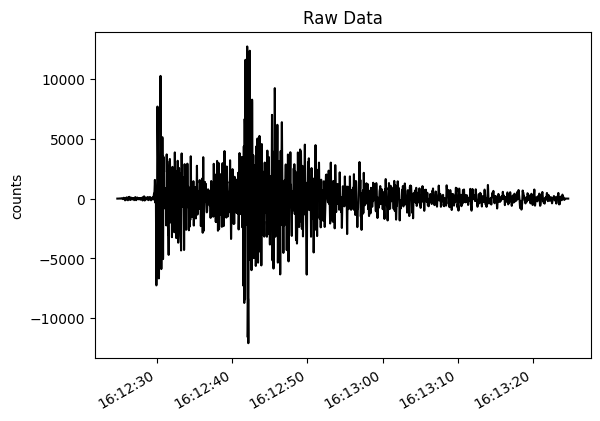

In [13]:
import obspy
import h5py
from obspy import UTCDateTime
import numpy as np
from obspy.clients.fdsn.client import Client
import matplotlib.pyplot as plt

def make_stream(dataset):
    '''
    input: hdf5 dataset
    output: obspy stream
    '''
    data = np.array(dataset)

    tr_E = obspy.Trace(data=data[:, 0])
    tr_E.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_E.stats.delta = 0.01
    tr_E.stats.channel = dataset.attrs['receiver_type']+'E'
    tr_E.stats.station = dataset.attrs['receiver_code']
    tr_E.stats.network = dataset.attrs['network_code']

    tr_N = obspy.Trace(data=data[:, 1])
    tr_N.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_N.stats.delta = 0.01
    tr_N.stats.channel = dataset.attrs['receiver_type']+'N'
    tr_N.stats.station = dataset.attrs['receiver_code']
    tr_N.stats.network = dataset.attrs['network_code']

    tr_Z = obspy.Trace(data=data[:, 2])
    tr_Z.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_Z.stats.delta = 0.01
    tr_Z.stats.channel = dataset.attrs['receiver_type']+'Z'
    tr_Z.stats.station = dataset.attrs['receiver_code']
    tr_Z.stats.network = dataset.attrs['network_code']

    stream = obspy.Stream([tr_E, tr_N, tr_Z])

    return stream

def make_plot(tr, title='', ylab=''):
    '''
    input: trace
    '''
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(tr.times("matplotlib"), tr.data, "k-")
    ax.xaxis_date()
    fig.autofmt_xdate()
    plt.ylabel('counts')
    plt.title('Raw Data')
    plt.show()

if __name__ == '__main__': 

    # reading one sample trace from STEAD
    dtfl = h5py.File(r"C:\Users\tolga\Documents\Uni\DSLab\earthquake-monitoring\data\STEAD\chunk2\chunk2.hdf5", 'r')
    dataset = dtfl.get('data/109C.TA_20061103161223_EV') 
    st = make_stream(dataset)
    

In [18]:
eqt_preds = eqt_model.annotate(st)
stream = st

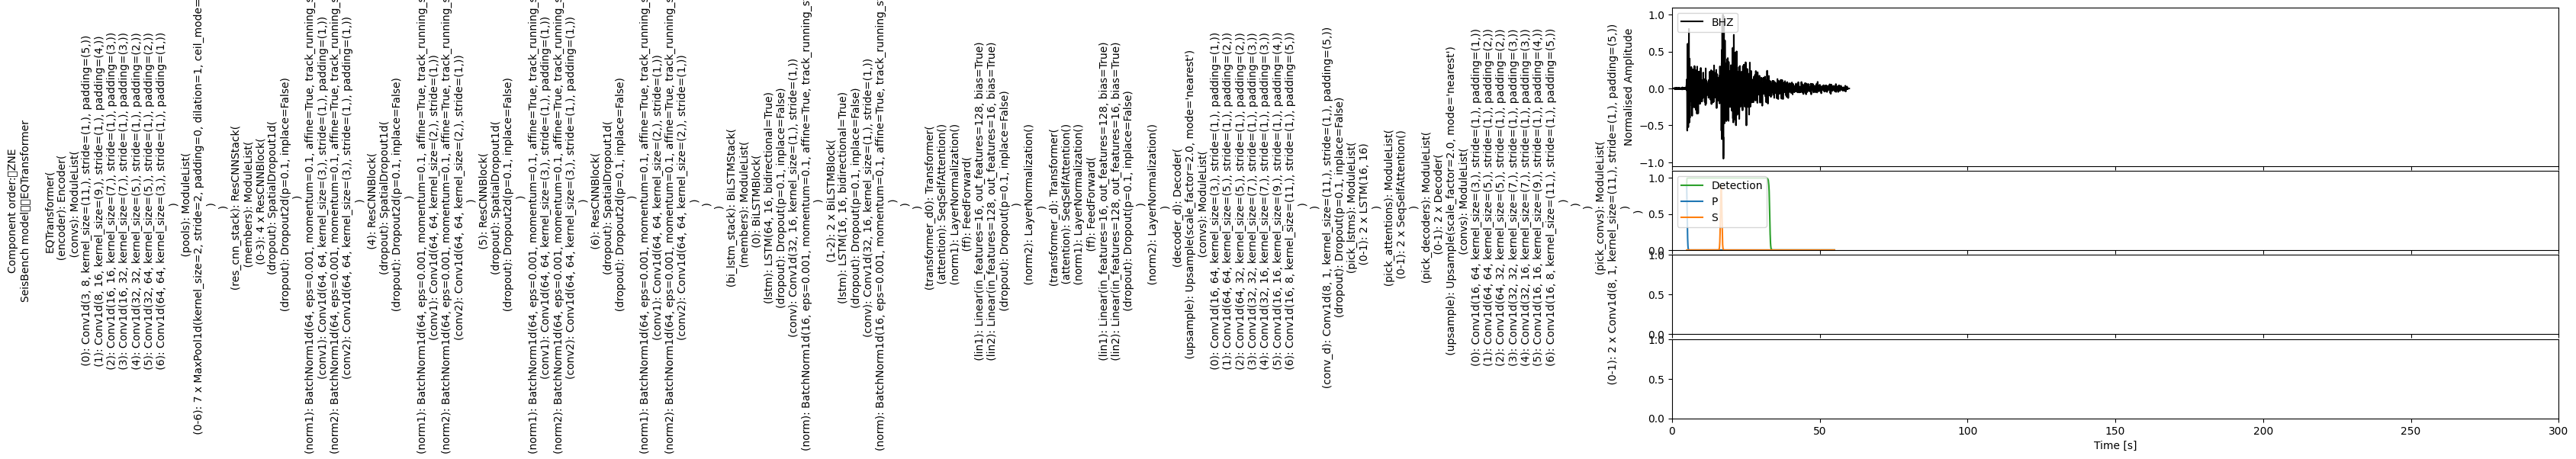

In [20]:
color_dict = {"P": "C0", "S": "C1", "Detection": "C2"}
wlength = 300
for s in range(0, int(stream[0].stats.endtime - stream[0].stats.starttime), wlength):
    t0 = stream[0].stats.starttime + s
    t1 = t0 + wlength
    subst = stream.slice(t0, t1)

    fig, ax = plt.subplots(4, 1, figsize=(15, 7), sharex=True, gridspec_kw={'hspace' : 0.05, 'height_ratios': [2, 1, 1, 1]})
    
    for i, preds in enumerate([eqt_preds]):
        subpreds = preds.slice(t0, t1)
        offset = subpreds[0].stats.starttime - subst[0].stats.starttime
        for pred_trace in subpreds:
            model, pred_class = pred_trace.stats.channel.split("_")
            if pred_class == "N":
                # Skip noise traces
                continue
            c = color_dict[pred_class]
            ax[i + 1].plot(offset + pred_trace.times(), pred_trace.data, label=pred_class, c=c)
        ax[i + 1].set_ylabel(eqt_model)
        ax[i + 1].legend(loc=2)
        ax[i + 1].set_ylim(0, 1.1)
    
    ax[0].plot(subst[-1].times(), subst[-1].data / np.amax(subst[-1].data), 'k', label=subst[-1].stats.channel)
    ax[0].set_xlim(0, wlength)
    ax[0].set_ylabel('Normalised Amplitude')
    ax[3].set_xlabel('Time [s]')
    ax[0].legend(loc=2)
    plt.show()

In [36]:
wlength = 300
t0 = stream[0].stats.starttime 
t1 = t0 + wlength
slices = eqt_preds.slice(t0, t1)

In [41]:
for trace in slices:
    

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [38]:
trace.data

2006-11-03T16:17:24.700000Z

In [1]:
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

In [2]:
data = sbd.STEAD(download_kwargs={"basepath": r"C:\Users\tolga\Documents\Uni\DSLab\earthquake-monitoring\data\STEAD\chunk2"})
train, dev, test = data.train_dev_test()

In [ ]:
eqt_model

In [3]:
dev_generator = sbg.GenericGenerator(dev)
batch_size = 32
num_workers = 1  # The number of threads used for loading data

dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

In [7]:
num_batches = len(dev_loader)
test_loss = 0
model = sbm.EQTransformer.from_pretrained("stead")
model.eval()  # close the model for evaluation

with torch.no_grad():
    for batch in dev_loader:
        #pred = model(batch["X"].to(model.device))
        #print(pred[0].shape)
        print(batch)
        break

{'X': tensor([[[-2.6191e+01, -2.6302e+01, -2.8879e+01,  ...,  1.3160e+02,
           4.6800e+01, -1.3351e+02],
         [-7.6309e+01, -7.0387e+01, -6.4939e+01,  ...,  6.2319e+02,
           1.9509e+03,  3.0814e+03],
         [-1.5847e+01, -7.4934e-01,  1.4340e+01,  ...,  6.7363e+03,
           6.1360e+03,  5.1646e+03]],

        [[ 0.0000e+00,  4.4249e-02,  1.0166e-01,  ...,  3.3177e-02,
           1.0515e-02,  0.0000e+00],
         [ 0.0000e+00,  1.7761e-02,  3.7240e-02,  ..., -5.4595e-03,
          -1.6545e-03, -0.0000e+00],
         [-0.0000e+00, -1.1694e-02, -2.6710e-02,  ..., -2.9921e-02,
          -5.2699e-03, -0.0000e+00]],

        [[ 0.0000e+00,  2.3291e-02,  6.7122e-02,  ...,  3.0995e-02,
           6.1582e-03,  0.0000e+00],
         [ 0.0000e+00,  2.8177e-02,  7.0145e-02,  ..., -7.6265e-03,
          -3.8600e-03, -0.0000e+00],
         [ 0.0000e+00,  2.1922e-02,  6.9932e-02,  ...,  1.0112e-04,
          -1.1179e-03, -0.0000e+00]],

        ...,

        [[ 0.0000e+00,  9.782

In [8]:
test